In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import beta
from scipy.stats import gamma
import matplotlib.pyplot as plt

from utils.visualisations import plot_reliability_diagram

from sklearn.utils import column_or_1d

from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize_scalar

from scipy.special import gamma
from scipy.special import beta as betaconst

from functools import partial

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = '#cccccc'
linspace = np.linspace(0.01, 0.99, 100)

eps = np.finfo(np.float).eps

def posterior(x, a0, b0, beta0, a1, b1, beta1):
    numerator = prior1 * ((x**(a1 - 1))*((1 - x)**(b1 - 1))) / beta1
    denominator = numerator + prior0 * ((x**(a0 - 1))*((1 - x)**(b0 - 1))) / beta0
    return np.divide(numerator, denominator)

def posterior1_intersection(s, intersect=0.5):
    return (posterior1(s) - intersect)**2

# TODO remove the following function (only for debug purposes)
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(1, module_path)
from betacal import BetaCalibration
def _test_plot_betacal(scores, labels, parameters="abm"):
    bcam = BetaCalibration(parameters=parameters)
    bcam.fit(scores, labels)
    map_beta = bcam.predict(linspace)
    plt.plot(linspace, map_beta)
    
map_beta = {}

# Distributions

We start by defining the probability density of each class. In this example, each class will follow a Beta distribution with class zero towards the left side and class one towards the right side.

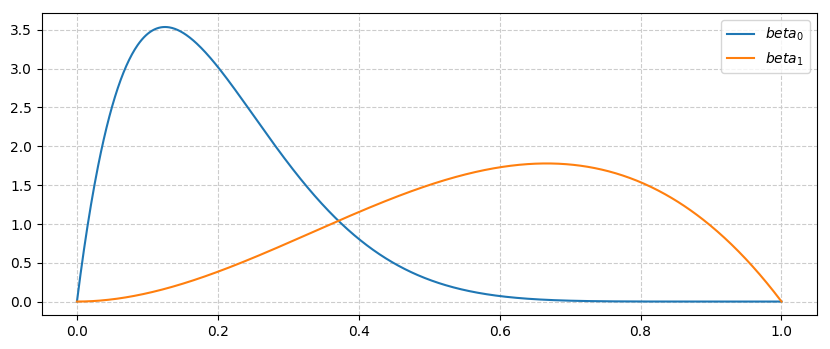

In [2]:
n_samples = 3000
prior0 = 0.5
prior1 = 1-prior0
a0 = 2
b0 = 8

a1 = 3
b1 = 2

linspace = np.linspace(0+eps, 1-eps, 1000)

plt.plot(linspace, beta.pdf(linspace, a0, b0), label='$beta_0$')
plt.plot(linspace, beta.pdf(linspace, a1, b1), label='$beta_1$')
plt.legend()

# Samples

Given the priors that we defined earlier we can sample from the joint distribution

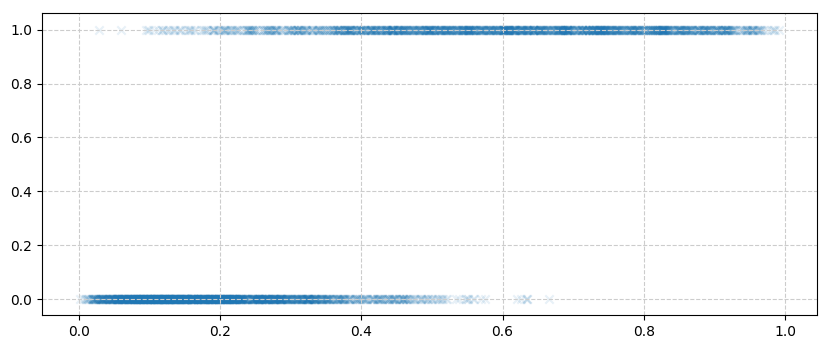

In [3]:
pos_x = np.random.beta(a0, b0, int(n_samples*prior0))
neg_x = np.random.beta(a1, b1, int(n_samples*prior1))

scores = np.hstack((pos_x, neg_x))
labels = np.hstack((np.zeros(int(n_samples*prior0)), np.ones(int(n_samples*prior1))))

plt.scatter(scores, labels, marker='x', alpha=0.1)

# Posterior probability of class 1

Because we know the probability density functions and the priors, we can visualize the posterior probability of class 1 given the $x$ value and the known parameters.

a0 = 2, b0 = 8, beta0 = 0.0138888888889, prior0 = 0.5
a1 = 3, b1 = 2, beta1 = 0.0833333333333, prior1 = 0.5
Original values :	 a = 1.00, b = 6.00, m = 0.37


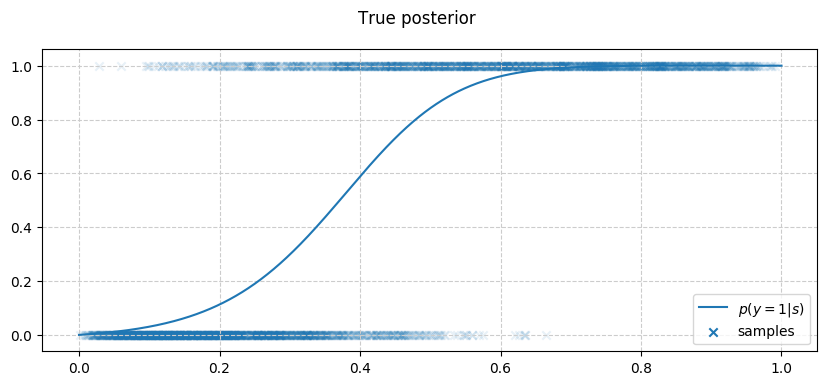

In [4]:
beta0 = betaconst(a0, b0)
beta1 = betaconst(a1, b1)
print('a0 = {}, b0 = {}, beta0 = {}, prior0 = {}'.format(a0, b0, beta0, prior0))
print('a1 = {}, b1 = {}, beta1 = {}, prior1 = {}'.format(a1, b1, beta1, prior1))

posterior1 = partial(posterior, a0=a0, b0=b0, beta0=beta0, a1=a1, b1=b1, beta1=beta1)
true_posterior = posterior1(linspace)

fig = plt.figure()
fig.suptitle('True posterior')
plt.scatter(scores, labels, marker='x', alpha=0.1, label='samples')
plt.plot(linspace, true_posterior, label='$p(y=1|s)$')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

def posterior1_intersection(s, intersect=0.5):
    return (posterior1(s) - intersect)**2

result = minimize_scalar(posterior1_intersection, bounds=[0, 1], method='bounded')
orig_m = result.x
orig_a = a1 - a0
orig_b = b0 - b1
print('Original values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(orig_a, orig_b, orig_m))

# $BetaCal(s; a,a, m| m=0.5)$

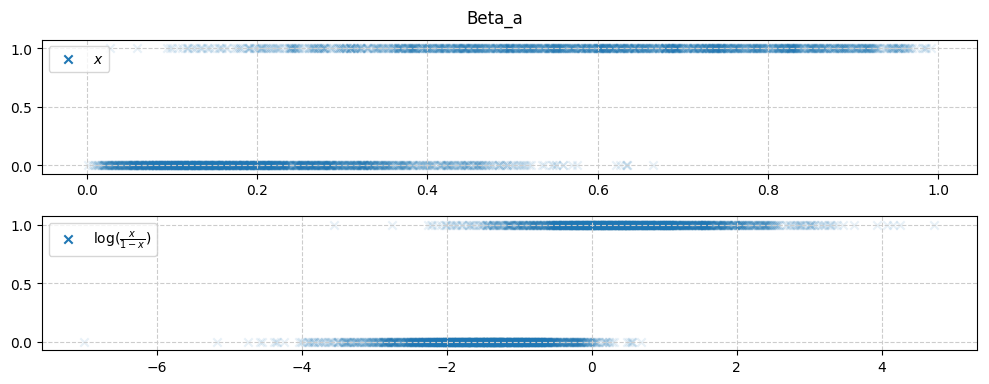

In [5]:
title = 'Beta_a'
fig = plt.figure()
fig.suptitle(title)

x = scores.reshape(-1, 1)
x = np.clip(x, eps, 1-eps)
ax = fig.add_subplot(211)
ax.scatter(x, labels, marker='x', alpha=0.1, label='$x$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x = np.log(x / (1. - x))
ax = fig.add_subplot(212)
ax.scatter(x, labels, marker='x', alpha=0.1, label=r'$\log(\frac{x}{1-x})$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Original values :	 a = 1.00, b = 6.00, m = 0.37
Estimated values :	 a = 1.75, b = 1.75, m = 0.50
a = 1.75113170862, b = 1.75113170862, m = 0.0


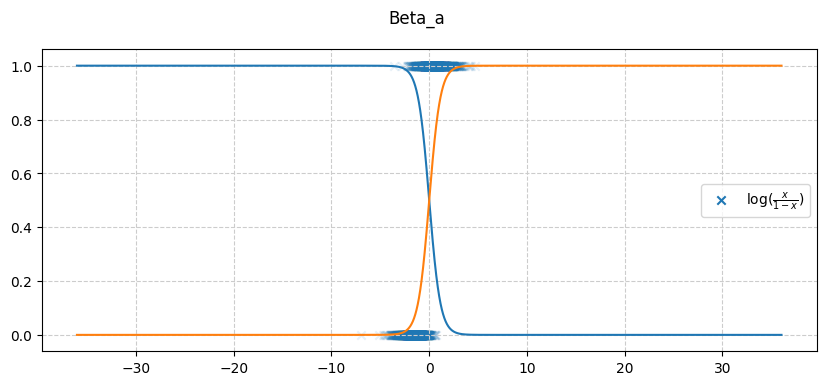

In [6]:
lr = LogisticRegression(fit_intercept=False, C=99999999999)
lr.fit(x, labels)
coefs = lr.coef_[0]
a = coefs[0]
b = a
m = 0.5

print('Original values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(orig_a, orig_b, orig_m))
print('Estimated values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))

fig = plt.figure()
fig.suptitle(title)
ax = fig.add_subplot(111)
ax.scatter(x, labels, marker='x', alpha=0.1, label=r'$\log(\frac{x}{1-x})$')

new_linspace = np.clip(linspace, eps, 1-eps).reshape(-1,1)
new_linspace = np.log(new_linspace / (1. - new_linspace))
ax.plot(new_linspace, lr.predict_proba(new_linspace))

ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)
    
bca = BetaCalibration(parameters="a")
bca.fit(scores, labels)
print("a = {}, b = {}, m = {}".format(bca.calibrator_.lr_.coef_[0][0],
                                      bca.calibrator_.lr_.coef_[0][0],
                                      bca.calibrator_.lr_.intercept_))

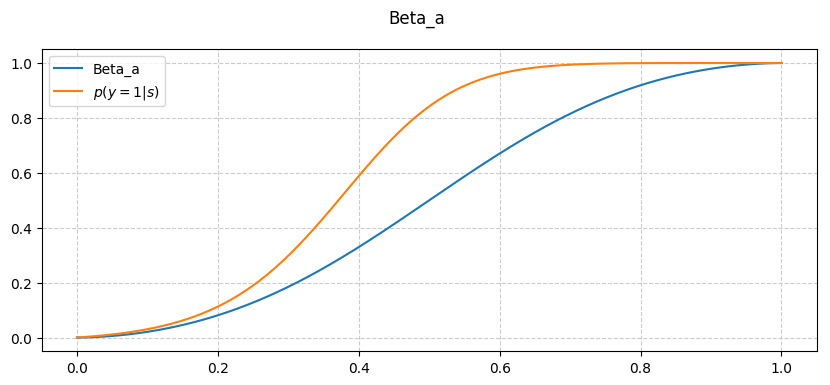

In [7]:
x_linspace = linspace.reshape(-1, 1)
x_linspace = np.log(x_linspace / (1. - x_linspace))
map_beta[title] = lr.predict_proba(x_linspace)[:, 1]
fig = plt.figure()
fig.suptitle(title)
plt.plot(linspace, map_beta[title], label=title)
plt.plot(linspace, true_posterior, label='$p(y=1|s)$')
plt.legend()

# $BetaCal(s; a,a,c) = LogisticCal(\ln\frac{s}{1-s}; a, c)$

**Proposition 1.** For any $a \ge 0$ and $c,s \in \mathbb{R}: \mu_{beta} (s; a,a,c) = \mu_{logistic}(\ln\frac{s}{1-s};a,c)$

__Proof.__ It is sufficient to prove that the corresponding likelihood ratios are equal.

$$
LR_{logistic}\left(\ln \frac{s}{1-s};a,c\right) = exp[a \ln \frac{s}{1-s}+c] \\
= \left(\frac{s}{1-s}\right)^a e^c = LR_{beta}(s;a,a,c)
$$

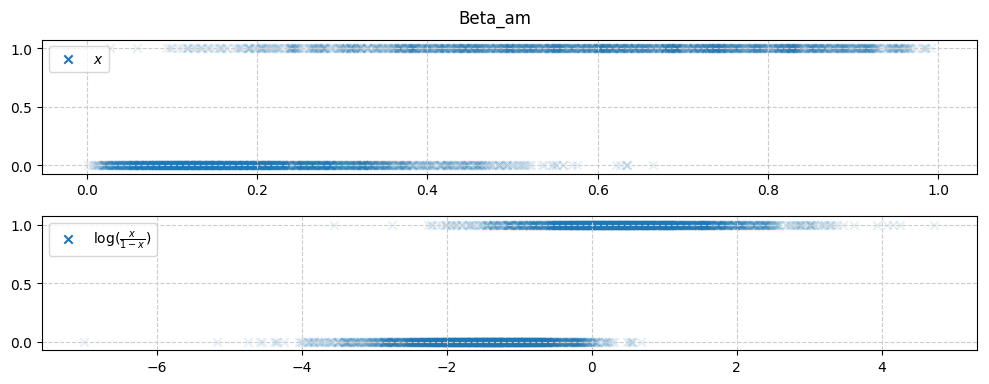

In [8]:
title = 'Beta_am'
fig = plt.figure()
fig.suptitle(title)

x = scores.reshape(-1, 1)
x = np.clip(x, eps, 1-eps)
ax = fig.add_subplot(211)
ax.scatter(x, labels, marker='x', alpha=0.1, label='$x$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x = np.log(x / (1. - x))
ax = fig.add_subplot(212)
ax.scatter(x, labels, marker='x', alpha=0.1, label=r'$\log(\frac{x}{1-x})$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Original values :	 a = 1.00, b = 6.00, m = 0.37
Estimated values :	 a = 2.64, b = 2.64, m = 0.36
a = 2.64088277616, b = 2.64088277616, m = [ 1.53459327]


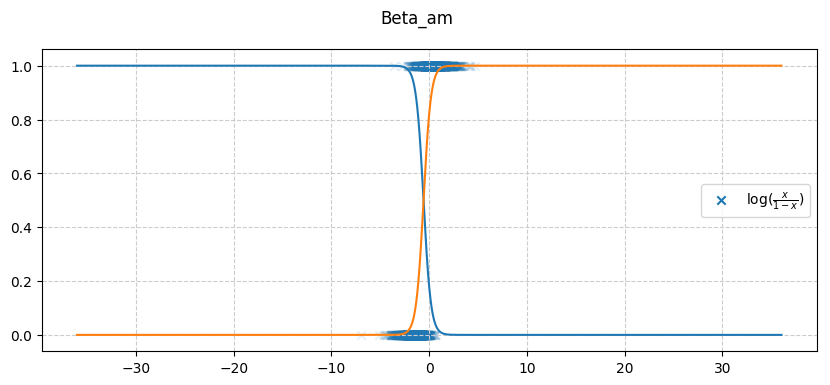

In [9]:
lr = LogisticRegression(C=99999999999)
lr.fit(x, labels)
coefs = lr.coef_[0]
inter = lr.intercept_[0]
a = coefs[0]
b = a
m = 1.0 / (1.0 + np.exp(inter / a))

print('Original values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(orig_a, orig_b, orig_m))
print('Estimated values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))

fig = plt.figure()
fig.suptitle(title)
ax = fig.add_subplot(111)
ax.scatter(x, labels, marker='x', alpha=0.1, label=r'$\log(\frac{x}{1-x})$')

new_linspace = np.clip(linspace, eps, 1-eps).reshape(-1,1)
new_linspace = np.log(new_linspace / (1. - new_linspace))
ax.plot(new_linspace, lr.predict_proba(new_linspace))

ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)
    
bcam = BetaCalibration(parameters="am")
bcam.fit(scores, labels)
print("a = {}, b = {}, m = {}".format(bcam.calibrator_.lr_.coef_[0][0],
                                      bcam.calibrator_.lr_.coef_[0][0],
                                      bcam.calibrator_.lr_.intercept_))

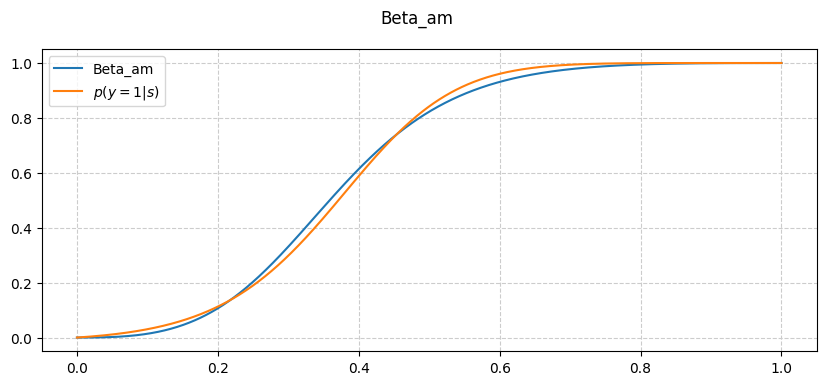

In [10]:
x_linspace = linspace.reshape(-1, 1)
x_linspace = np.log(x_linspace / (1. - x_linspace))
map_beta[title] = lr.predict_proba(x_linspace)[:, 1]
fig = plt.figure()
fig.suptitle(title)
plt.plot(linspace, map_beta[title], label=title)
plt.plot(linspace, true_posterior, label='$p(y=1|s)$')
plt.legend()

# $BetaCal(a, b, m|m=0.5)$

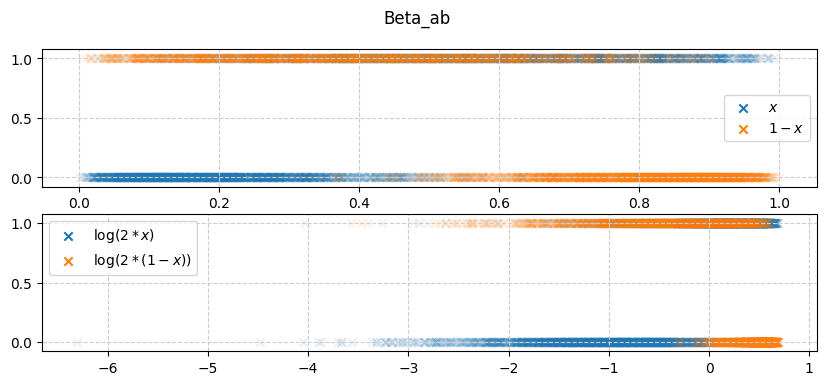

In [11]:
title = 'Beta_ab'
fig = plt.figure()
fig.suptitle(title)

x = scores.reshape(-1, 1)
x = np.clip(x, eps, 1-eps)

x = np.hstack((x, 1. - x))
ax = fig.add_subplot(211)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$x$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$1-x$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x = np.log(2 * x)
ax = fig.add_subplot(212)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$\log(2*x)$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$\log(2*(1-x))$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

Original values :	 a = 1.00, b = 6.00, m = 0.37
Estimated values :	 a = -0.02, b = 4.79, m = 0.50


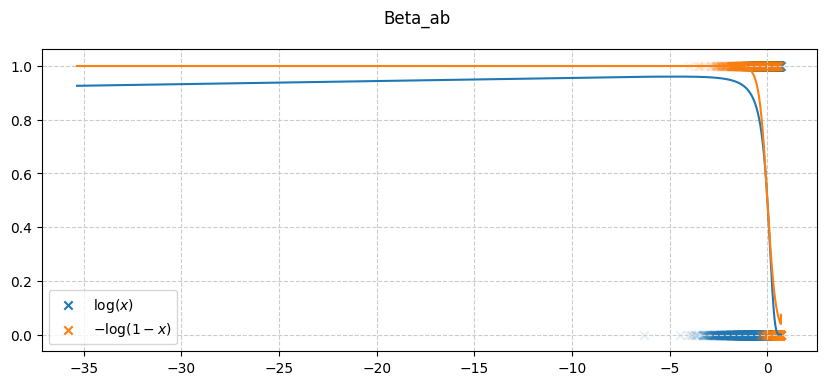

In [12]:
lr = LogisticRegression(fit_intercept=False, C=99999999999)
lr.fit(x, labels)
coefs = lr.coef_[0]
a = coefs[0]
b = -coefs[1]
m = 0.5

print('Original values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(orig_a, orig_b, orig_m))
print('Estimated values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))

fig = plt.figure()
fig.suptitle(title)
ax = fig.add_subplot(111)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$\log(x)$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$-\log(1-x)$')

new_linspace = np.clip(linspace, eps, 1-eps).reshape(-1,1)
new_linspace = np.hstack((new_linspace, 1. - new_linspace))
new_linspace = np.log(2 * new_linspace)
ax.plot(new_linspace, lr.predict_proba(new_linspace))

ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

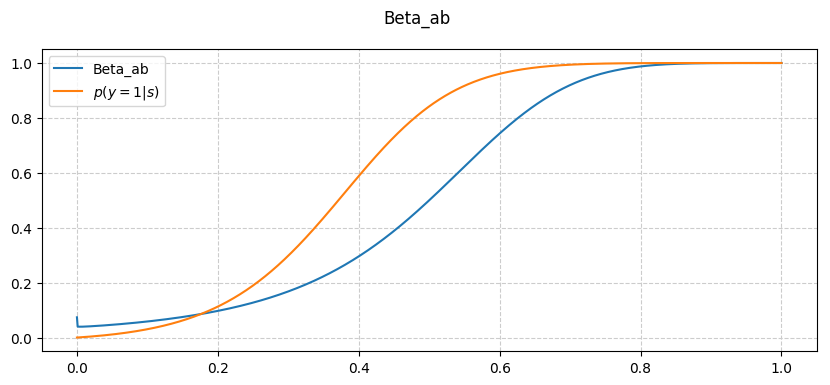

In [13]:
x_linspace = np.hstack((linspace.reshape(-1, 1), 1. - linspace.reshape(-1,1)))
x_linspace = np.log(2 * x_linspace)
map_beta[title] = lr.predict_proba(x_linspace)[:, 1]
fig = plt.figure()
fig.suptitle(title)
plt.plot(linspace, map_beta[title], label=title)
plt.plot(linspace, true_posterior, label='$p(y=1|s)$')
plt.legend()

# $BetaCal(s; a,b,c) = BiLogisticCal(\ln s, -\ln (1-s); a, b, c)$

Preprocessing steps of the initial scores in order to apply Logistic Regression

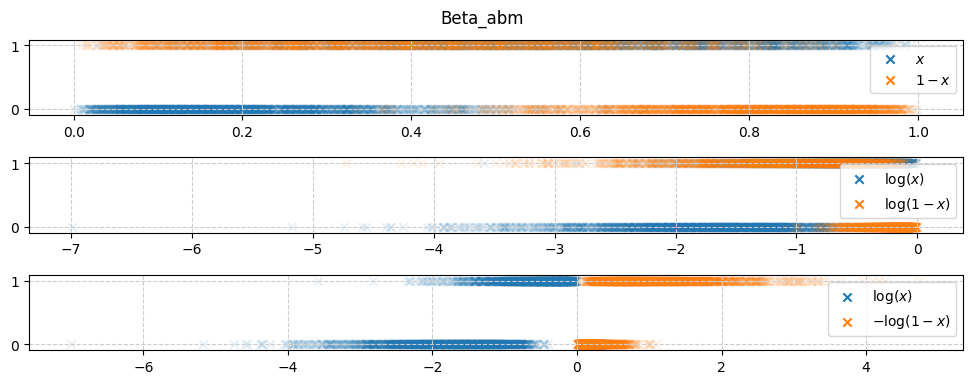

In [14]:
title = 'Beta_abm'
fig = plt.figure()
fig.suptitle(title)

x = scores.reshape(-1, 1)

x = np.clip(x, eps, 1-eps)
x = np.hstack((x, 1. - x))
ax = fig.add_subplot(311)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$x$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$1-x$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x = np.log(x)
ax = fig.add_subplot(312)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$\log(x)$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$\log(1-x)$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x[:, 1] *= -1
ax = fig.add_subplot(313)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$\log(x)$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$-\log(1-x)$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

We can visualise the new bivariate gaussians

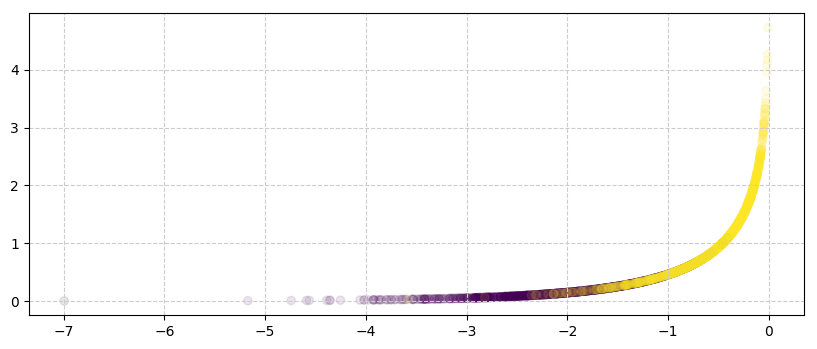

In [15]:
plt.scatter(x[:,0], x[:,1], c=labels, alpha=0.1)

Now we can apply Logistic Regression to the new scores

Original values :	 a = 1.00, b = 6.00, m = 0.37
Estimated values :	 a = 0.76, b = 6.40, m = 0.38


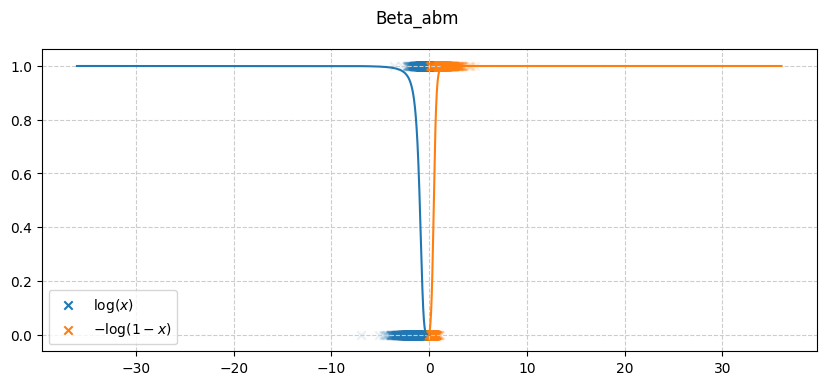

In [16]:
lr = LogisticRegression(C=99999999999)
lr.fit(x, labels)
coefs = lr.coef_[0]
inter = lr.intercept_
a = coefs[0]
b = coefs[1]

m = minimize_scalar(lambda mh: np.abs(b*np.log(1.-mh)-a*np.log(mh)-inter),
                    bounds=[0, 1], method='Bounded').x[0]

print('Original values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(orig_a, orig_b, orig_m))
print('Estimated values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))

fig = plt.figure()
fig.suptitle(title)
ax = fig.add_subplot(111)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$\log(x)$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$-\log(1-x)$')

new_linspace = np.clip(linspace, eps, 1-eps).reshape(-1,1)
new_linspace = np.hstack((new_linspace, 1. - new_linspace))
new_linspace = np.log(new_linspace)
new_linspace[:, 1] *= -1
ax.plot(new_linspace, lr.predict_proba(new_linspace))

ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

The resulting map

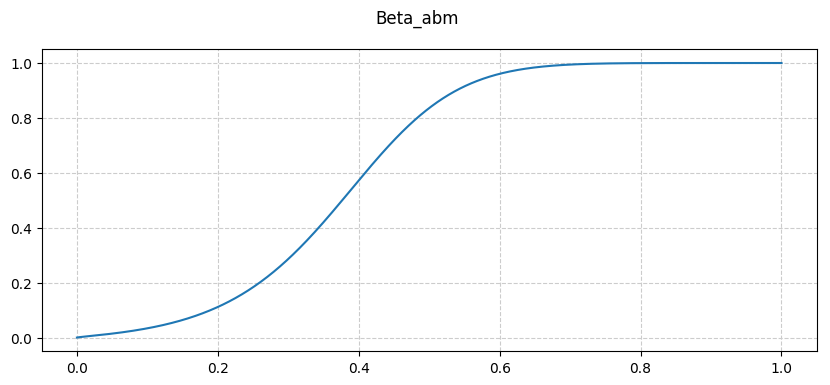

In [17]:
x_linspace = np.hstack((linspace.reshape(-1, 1), 1. - linspace.reshape(-1,1)))
x_linspace = np.log(x_linspace)
x_linspace[:, 1] *= -1
map_beta[title] = lr.predict_proba(x_linspace)[:, 1]
fig = plt.figure()
fig.suptitle(title)
plt.plot(linspace, map_beta[title])

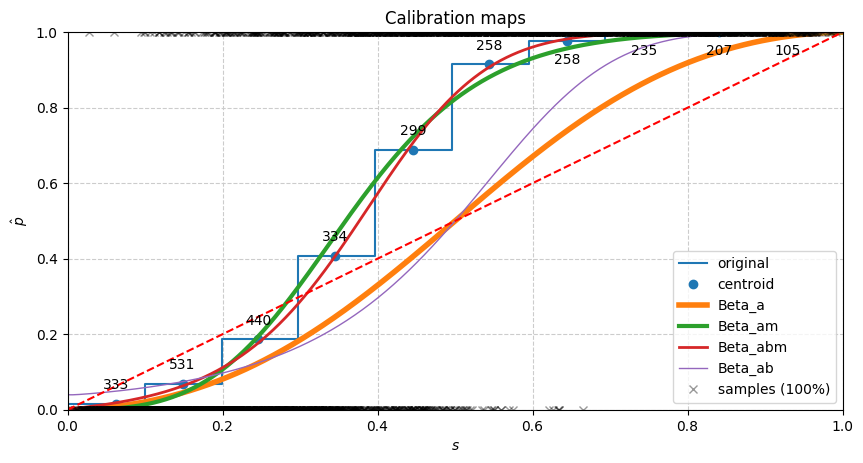

In [18]:
fig = plt.figure('rel_map', figsize=(10,5))
fig = plot_reliability_diagram(scores, labels, linspace,
                         map_beta.values(),
                         legend_set=map_beta.keys(),
                         alpha=1e-12, scatter_prop=1.0,
                         title='Calibration maps',
                         fig=fig)

In [19]:
posterior_values = posterior1(linspace)
for key, value in map_beta.items():
    print('{} MSE = {:.3E}'.format(key.ljust(12), np.mean((posterior_values - value)**2)))

Beta_a       MSE = 3.207E-02
Beta_am      MSE = 3.586E-04
Beta_abm     MSE = 4.445E-05
Beta_ab      MSE = 2.739E-02
